# Hy's Law Plots for Office of Women's Health 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob
import matplotlib.pylab as plt
from matplotlib.ticker import NullFormatter
from numpy.polynomial.polynomial import polyfit

import os, math
import numpy as np

from send import send_db

In [2]:
import re

def filter_text(x):
    
    """ returns null if x does not contain a valid numeric response,
    else it extracts that using a regex pattern """
    digit_pattern = r'[-+]?([0-9]*\.[0-9]+|[0-9]+)'
    digit_extract = re.search(digit_pattern, str(x))
    if digit_extract:
        return float(digit_extract.group(0))
    return np.nan

def regrex_match(regrex, string: str):
    """ generic function to just max a string of text """
    pattern = re.compile(regrex, re.IGNORECASE)
    match = pattern.search(string)
    if match:
        return True
    return False


def is_cholestasis(finding: str):
    """ takes a text string from an MI finding and classifies whether or not
        the finding can be classified as cholestasis

        wikipedia link for Cholestasis: https://en.wikipedia.org/wiki/Cholestasis
    """
    regrex = r'chol(e|o|a)|bil(i|e)'
    return regrex_match(regrex, finding)

def is_steatosis(finding: str):

    """ takes a text string from an MI finding and classifies whether or not
        the finding can be classified as steatosis

        wikipedia link for steatosis: https://en.wikipedia.org/wiki/Steatosis
    """
    steatosis_regrex = r'fat|lipid|vacuol|acc|steat|congest'
    increased_regrex = r'decreas|lower'
    return regrex_match(steatosis_regrex, finding) and not regrex_match(increased_regrex, finding)

def is_necrosis(finding: str):
    """ takes a text string from an MI finding and classifies whether or not
        the finding can be classified as necrosis

        """
    steatosis_regrex = r'necros|fibros|degen|atroph|apop|deplet'
    return regrex_match(steatosis_regrex, finding)


def classify_helper(helper_fx, findings):
    """ goes through all the findings and returns if the helper function results in true """
    for finding in findings:
        if helper_fx(finding):
            return 1
    return 0

from functools import partial
classify_steatosis = partial(classify_helper, is_steatosis)
classify_cholestasis = partial(classify_helper, is_cholestasis)
classify_necrosis = partial(classify_helper, is_necrosis)

def get_classified_liver_results():
    """ will pull all liver results and classfy them as either necrosis, steatosis, cholestasis """
    mi = send_db.generic_query('SELECT STUDYID, USUBJID, MISTRESC FROM MI WHERE MISPEC="LIVER"')
    mi['STEATOSIS'] = mi.groupby(['STUDYID', 'USUBJID'])['MISTRESC'].transform(classify_steatosis)
    mi['CHOLESTASIS'] = mi.groupby(['STUDYID', 'USUBJID'])['MISTRESC'].transform(classify_cholestasis)
    mi['NECROSIS'] = mi.groupby(['STUDYID', 'USUBJID'])['MISTRESC'].transform(classify_necrosis)
    mi['MISTRESC'] = mi.groupby(['STUDYID', 'USUBJID'])['MISTRESC'].transform(lambda x: ';'.join(x))
    return mi.drop_duplicates(['STUDYID', 'USUBJID'])

# Set Global Variables

There are two global variables that need to be set relative to the ineractive eDISH plots that will be made.  

1) `SPECIES`: the species, in SEND controlled terminology to be used to create plots.  
2) `LBSPEC`: the specimen, in SEND controlled terminology to be used for the ALT and BILI responses.  This refers to the "tissue" or "component" the sample is taken from (i.e., plasma or serum).  

In [3]:
SPECIES = 'RAT'
LBSPEC = 'SERUM'

### Select animals

In [4]:
animals = send_db.get_all_animals()
animals = animals[animals.SPECIES == SPECIES]
print(animals.head())

     STUDYID  ID        USUBJID SPECIES          STRAIN SEX
54  00086623   1  00086623-1001     RAT  SPRAGUE-DAWLEY   M
55  00086623   1  00086623-1002     RAT  SPRAGUE-DAWLEY   M
56  00086623   1  00086623-1003     RAT  SPRAGUE-DAWLEY   M
57  00086623   1  00086623-1004     RAT  SPRAGUE-DAWLEY   M
58  00086623   1  00086623-1005     RAT  SPRAGUE-DAWLEY   M


Get all the ALT and BILI responses from for the target animals. 

In [5]:
clin_chem = send_db.generic_query(f'SELECT USUBJID, LBTESTCD, LBSPEC, LBSTRESC, LBSTRESU FROM LB WHERE (LBTESTCD == "ALT" OR LBTESTCD == "BILI") AND (LBSPEC == "{LBSPEC}")')

clin_chem = clin_chem[clin_chem.USUBJID.isin(animals.USUBJID)]

print(clin_chem.head())

         USUBJID LBTESTCD LBSPEC LBSTRESC LBSTRESU
0  8391504-R0001      ALT  SERUM       45      U/L
1  8391504-R0001      ALT  SERUM       34      U/L
2  8391504-R0001     BILI  SERUM     <0.1    mg/dL
3  8391504-R0001     BILI  SERUM      0.1    mg/dL
4  8391504-R0002      ALT  SERUM       34      U/L


### Check unit for ALT and BILI.

From previous tests, there appears to be only 2 unique units provided for each test.  

ALT -> UI/L or IU/L or ukat/L  
BILI -> mg/dL or umol/L

In [6]:
print("Unique ALT tests: ", clin_chem[clin_chem.LBTESTCD == 'ALT'].LBSTRESU.unique())
print("Unique BILI tests: ", clin_chem[clin_chem.LBTESTCD == 'BILI'].LBSTRESU.unique())

Unique ALT tests:  ['U/L' '' 'IU/L' 'ukat/L']
Unique BILI tests:  ['mg/dL' '' 'umol/L']


### Conversion

1) Remove unitless responses  
2) Use `filter_text` to extract numeric values from discrete responses (e.g., <0.1)   
3a) ALT -> convert ukat/L to IU/L or U/L by multiplying by 1/0.0167  
3b) BILI -> convert umol/L  to mg/dL by multiplying by 1/17.104    

In [7]:

clin_chem = clin_chem[clin_chem.LBSTRESU != '']

clin_chem['LBSTRESC_T'] = clin_chem.LBSTRESC.apply(filter_text)
clin_chem = clin_chem[clin_chem.LBSTRESC_T.notnull()]

clin_chem['LBSTRESC_CONV'] = clin_chem.LBSTRESC_T

clin_chem.loc[(clin_chem.LBTESTCD == 'ALT') & (clin_chem.LBSTRESU == 'ukat/L'), 'LBSTRESC_CONV'] = clin_chem.loc[(clin_chem.LBTESTCD == 'ALT') & (clin_chem.LBSTRESU == 'ukat/L'), 'LBSTRESC_T'] * (1/0.0167)
clin_chem.loc[(clin_chem.LBTESTCD == 'BILI') & (clin_chem.LBSTRESU == 'umol/L'), 'LBSTRESC_CONV'] = clin_chem.loc[(clin_chem.LBTESTCD == 'BILI') & (clin_chem.LBSTRESU == 'umol/L'), 'LBSTRESC_T'] * (1/17.104)
clin_chem.head()

,USUBJID,LBTESTCD,LBSPEC,LBSTRESC,LBSTRESU,LBSTRESC_T,LBSTRESC_CONV
0,8391504-R0001,ALT,SERUM,45,U/L,45.0,45.0
1,8391504-R0001,ALT,SERUM,34,U/L,34.0,34.0
2,8391504-R0001,BILI,SERUM,<0.1,mg/dL,0.1,0.1
3,8391504-R0001,BILI,SERUM,0.1,mg/dL,0.1,0.1
4,8391504-R0002,ALT,SERUM,34,U/L,34.0,34.0


### Transform data

Merge the converted data with the animal meta data, then take the max response for each animal/LBTESTCD.

Pivot the data from long to wide format.

In [8]:
animal_clin_chem = animals.merge(clin_chem)

animal_clin_chem.loc[:, 'LBSTRESC_MAX'] = animal_clin_chem.groupby(['STUDYID', 'USUBJID',  'LBTESTCD'])['LBSTRESC_CONV'].transform('max')
max_responses = animal_clin_chem.drop_duplicates(['STUDYID', 'USUBJID',  'LBTESTCD'])


data = max_responses.pivot_table(index=['STUDYID', 'USUBJID'], 
                                            columns='LBTESTCD', 
                                            values='LBSTRESC_MAX').reset_index()

data = data[data[['ALT', 'BILI']].notnull().all(1)]

animal_data = animals.merge(data)
print(animal_data.head())

    STUDYID  ID        USUBJID SPECIES          STRAIN SEX   ALT  BILI
0  00086624   1  00086624-1001     RAT  SPRAGUE-DAWLEY   M  58.0   0.0
1  00086624   1  00086624-1002     RAT  SPRAGUE-DAWLEY   M  80.0   0.0
2  00086624   1  00086624-1003     RAT  SPRAGUE-DAWLEY   M  85.0   0.1
3  00086624   1  00086624-1004     RAT  SPRAGUE-DAWLEY   M  77.0   0.0
4  00086624   1  00086624-1005     RAT  SPRAGUE-DAWLEY   M  82.0   0.1


### Merge histopath findings

In [9]:
liver_findings = get_classified_liver_results()

animal_data = animal_data.merge(liver_findings)
print(animal_data.head())

    STUDYID  ID        USUBJID SPECIES          STRAIN SEX   ALT  BILI  \
0  00086624   1  00086624-1001     RAT  SPRAGUE-DAWLEY   M  58.0   0.0   
1  00086624   1  00086624-1002     RAT  SPRAGUE-DAWLEY   M  80.0   0.0   
2  00086624   1  00086624-1003     RAT  SPRAGUE-DAWLEY   M  85.0   0.1   
3  00086624   1  00086624-1004     RAT  SPRAGUE-DAWLEY   M  77.0   0.0   
4  00086624   1  00086624-1005     RAT  SPRAGUE-DAWLEY   M  82.0   0.1   

                         MISTRESC  STEATOSIS  CHOLESTASIS  NECROSIS  
0  Infiltration, mononuclear cell          0            0         0  
1                          NORMAL          0            0         0  
2                          NORMAL          0            0         0  
3  Infiltration, mononuclear cell          0            0         0  
4  Infiltration, mononuclear cell          0            0         0  


### Load Bokeh

Bokeh is nice for interactions, so load that for these plots.

In [10]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

### Establishing upper limit of normal 

For this we'll need to identify control animals.  The `send_db` object has a useful function to get control animals.  

After that we plot the log normal distrubtions of the 

In [11]:
control_animals = send_db.get_control_animals().merge(animals)
control_animals_data = control_animals.merge(data)
control_animals_data.head()

,STUDYID,ID,USUBJID,SPECIES,STRAIN,SEX,SETCD,TXVAL,ALT,BILI
0,00086624,1,00086624-1001,RAT,SPRAGUE-DAWLEY,M,1M,Vehicle,58.0,0.0
1,00086624,1,00086624-1002,RAT,SPRAGUE-DAWLEY,M,1M,Vehicle,80.0,0.0
2,00086624,1,00086624-1003,RAT,SPRAGUE-DAWLEY,M,1M,Vehicle,85.0,0.1
3,00086624,1,00086624-1004,RAT,SPRAGUE-DAWLEY,M,1M,Vehicle,77.0,0.0
4,00086624,1,00086624-1005,RAT,SPRAGUE-DAWLEY,M,1M,Vehicle,82.0,0.1


In [12]:
def make_histogram(data, title, n_bins=100):
    """ make a bokeh histogram from a log normal distribution """
    import numpy as np
    from scipy.stats import lognorm
    
    hist, edges = np.histogram(data, density=True, bins=n_bins)
    f = figure(tools='box_zoom', background_fill_color="#fafafa", title=title)
    f.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)

    # lognormal distribution 
    s, loc, scale =  lognorm.fit(data, floc=0)
    xmin = data.min()
    xmax = data.max()
    x = np.linspace(xmin, xmax, 100)
    pdf = lognorm.pdf(x, s, scale=scale)
    
    max_95 = lognorm.ppf(0.95, s, scale=scale)
    f.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="PDF")
    vline = Span(location=max_95, dimension='height', line_dash='dotdash', line_color="black", line_alpha=0.7, line_width=3)
    f.line([], [], legend_label='ULN', line_dash='dotdash', line_color="black", line_alpha=0.7, line_width=3)
    f.renderers.extend([vline])
    return f , max_95

In [13]:
ULNs = {}

alt_data_M = control_animals_data.loc[control_animals_data.SEX == 'M', 'ALT']
alt_data_F = control_animals_data.loc[control_animals_data.SEX == 'F', 'ALT']
bili_data_M = control_animals_data.loc[control_animals_data.SEX == 'M', 'BILI']+0.001
bili_data_F = control_animals_data.loc[control_animals_data.SEX == 'F', 'BILI']+0.001


alt_m_f, ULNs['ALT - M'] = make_histogram(alt_data_M, 'ALT - Male')
alt_f_f, ULNs['ALT - F'] = make_histogram(alt_data_F, 'ALT - Female')
bili_m_f, ULNs['BILI - M'] = make_histogram(bili_data_M, 'BILI - Male', n_bins=50)
bili_f_f, ULNs['BILI - F'] = make_histogram(bili_data_F, 'BILI - Female', n_bins=50)

show(gridplot([[alt_m_f, alt_f_f],
               [bili_m_f, bili_f_f]]))

### Controls

Add a label if they're control or not

In [14]:
animal_data.loc[:, 'IS_CONTROL'] = animal_data.USUBJID.isin(control_animals.USUBJID)

In [15]:
animal_data

,STUDYID,ID,USUBJID,SPECIES,STRAIN,SEX,ALT,BILI,MISTRESC,STEATOSIS,CHOLESTASIS,NECROSIS,IS_CONTROL
0,00086624,1,00086624-1001,RAT,SPRAGUE-DAWLEY,M,58.0,0.00,"Infiltration, mononuclear cell",0,0,0,True
1,00086624,1,00086624-1002,RAT,SPRAGUE-DAWLEY,M,80.0,0.00,NORMAL,0,0,0,True
2,00086624,1,00086624-1003,RAT,SPRAGUE-DAWLEY,M,85.0,0.10,NORMAL,0,0,0,True
3,00086624,1,00086624-1004,RAT,SPRAGUE-DAWLEY,M,77.0,0.00,"Infiltration, mononuclear cell",0,0,0,True
4,00086624,1,00086624-1005,RAT,SPRAGUE-DAWLEY,M,82.0,0.10,"Infiltration, mononuclear cell",0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33881,XV33LT,1,XV33LT-4627,RAT,SPRAGUE-DAWLEY,F,109.0,0.20,NORMAL,0,0,0,False
33882,XV33LT,1,XV33LT-4629,RAT,SPRAGUE-DAWLEY,F,105.0,0.20,NORMAL,0,0,0,False
33883,XV33LT,1,XV33LT-4630,RAT,SPRAGUE-DAWLEY,F,91.0,0.20,NORMAL,0,0,0,False
33884,XV33LT,1,XV33LT-4639,RAT,SPRAGUE-DAWLEY,F,66.0,0.46,NORMAL,0,0,0,False


In [16]:
from sklearn import linear_model

no_controls = animal_data[~animal_data.IS_CONTROL]
male_X = no_controls[no_controls.SEX == 'M'][['ALT', 'BILI']]
male_y =  no_controls[no_controls.SEX == 'M'][['NECROSIS']]

male_X[['ALT', 'BILI']] = male_X[['ALT', 'BILI']] + abs(male_X[['ALT', 'BILI']].min().min()) + 1

male_X[['ALT', 'BILI']] = male_X[['ALT', 'BILI']].applymap(math.log10)

male_X['ALT*BILI'] = male_X['ALT'] * male_X['BILI']

clf = linear_model.LogisticRegression()
fitted_model = clf.fit(male_X, male_y)

In [17]:
male_X

,ALT,BILI,ALT*BILI
21,1.934498,0.000000,0.000000
22,1.748188,0.000000,0.000000
23,1.963788,0.000000,0.000000
24,1.838849,0.000000,0.000000
25,2.093422,0.000000,0.000000
...,...,...,...
33876,2.139879,0.079181,0.169438
33877,2.181844,0.079181,0.172761
33878,2.206826,0.079181,0.174739
33879,1.724276,0.079181,0.136530


In [18]:
fitted_model.score(male_X, male_y)

0.9364348226623675

In [19]:
theta = np.concatenate([fitted_model.intercept_, fitted_model.coef_[0]])

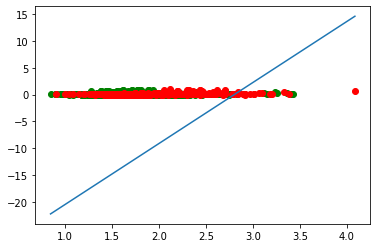

In [20]:
plt.scatter(male_X.ALT[(male_y.NECROSIS == 0)], male_X.BILI[(male_y.NECROSIS == 0)], c='g')
plt.scatter(male_X.ALT[(male_y.NECROSIS == 1)], male_X.BILI[(male_y.NECROSIS == 1)], c='r')


x = np.linspace(male_X.ALT.min(), male_X.ALT.max(), 50)

y = -(theta[0] + theta[1]*x)/theta[2]
plt.plot(x, y)


array([-22.25341861, -21.50109763, -20.74877665, -19.99645568,
       -19.2441347 , -18.49181372, -17.73949275, -16.98717177,
       -16.23485079, -15.48252982, -14.73020884, -13.97788786,
       -13.22556689, -12.47324591, -11.72092493, -10.96860395,
       -10.21628298,  -9.463962  ,  -8.71164102,  -7.95932005,
        -7.20699907,  -6.45467809,  -5.70235712,  -4.95003614,
        -4.19771516,  -3.44539419,  -2.69307321,  -1.94075223,
        -1.18843125,  -0.43611028,   0.3162107 ,   1.06853168,
         1.82085265,   2.57317363,   3.32549461,   4.07781558,
         4.83013656,   5.58245754,   6.33477851,   7.08709949,
         7.83942047,   8.59174145,   9.34406242,  10.0963834 ,
        10.84870438,  11.60102535,  12.35334633,  13.10566731,
        13.85798828,  14.61030926])